In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [29]:
# Using the GPU if it exists
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [30]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
#three channels this time for input.
train_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

for x,y in train_loader:
  print(x.shape)
  break



torch.Size([64, 3, 32, 32])


In [31]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32 , kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64 * 8 * 8, 512)
        self.bn1 = nn.BatchNorm2d(32) #normalize activation
        self.linear2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm2d(64)
        self.linear3 = nn.Linear(256,100)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
      x = self.relu(self.bn1(self.conv1(x)))
      x = self.pool(x)
      x = self.relu(self.bn2(self.conv2(x)))
      x = self.pool(x)
      x = self.dropout(x)
      x = self.flatten(x)
      x = self.relu(self.linear1(x))
      x = self.linear2(x)
      x = self.relu(x)
      x = self.linear3(x)
      return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..1.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47450978..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].


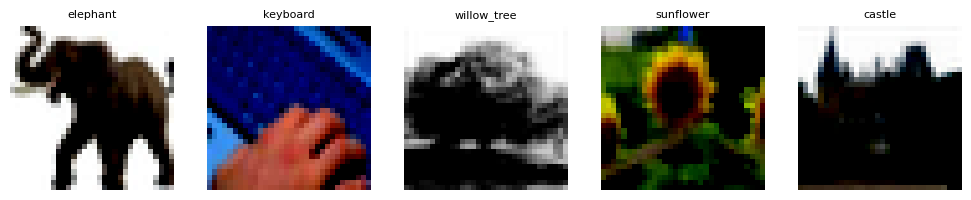

In [32]:
# Get class names
classes = train_data.classes

# Plot first 5 images
plt.figure(figsize=(10, 2))

for i in range(5):
    image, label = train_data[i+9]
    image = image.permute(1, 2, 0)  # from [C, H, W] to [H, W, C]

    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title(classes[label], fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def train(model,loader,optimizer,loss_fn,epochs = 5):
  model.train()
  for epoch in range(epochs):
      total_loss = 0
      for x, y in loader:
          x, y = x.to(device), y.to(device)
          optimizer.zero_grad()
          logits = model(x)
          loss = loss_fn(logits, y)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
      print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


def test(model,loader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for x, y in loader:
      x, y = x.to(device), y.to(device)
      logits = model(x)
      total += y.size(0)
      predicted = torch.argmax(logits, dim=1)
      correct += (predicted == y).sum().item()
  print(f"Accuracy: {100 * correct / total}%")



In [34]:
model = MyModel()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train(model,train_loader,optimizer,loss_fn,epochs=10)
test(model,test_loader)

Epoch 1, Loss: 2765.6714
Epoch 2, Loss: 2261.1962
Epoch 3, Loss: 2040.5258
Epoch 4, Loss: 1900.4840
Epoch 5, Loss: 1792.6165
Epoch 6, Loss: 1711.2634
Epoch 7, Loss: 1644.8416
Epoch 8, Loss: 1578.7269
Epoch 9, Loss: 1533.4669
Epoch 10, Loss: 1480.4590
Accuracy: 45.07%


Epoch 1, Loss: 1019.7338
Epoch 2, Loss: 997.6683
Epoch 3, Loss: 985.2469
Epoch 4, Loss: 972.2390
Epoch 5, Loss: 969.9283
Epoch 6, Loss: 951.5619
Epoch 7, Loss: 946.6246
Epoch 8, Loss: 935.6051
Epoch 9, Loss: 913.0375
Epoch 10, Loss: 908.2998
Accuracy: 48.07%


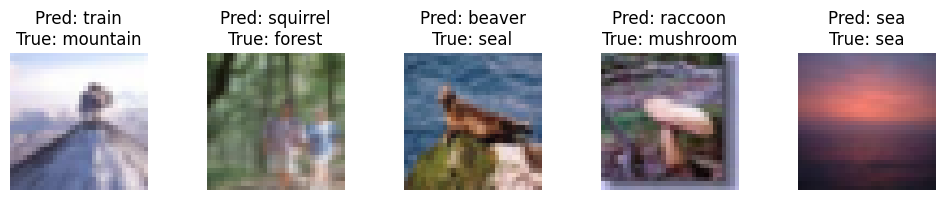

In [37]:
train(model,train_loader,optimizer,loss_fn,epochs=10)
test(model,test_loader) #why is accuracy not improving?
# Visualize some predictions
def visualize_predictions(model, loader, num_images=5):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        image = images[i].cpu().permute(1, 2, 0).numpy()
        image = (image * 0.5) + 0.5  # unnormalize
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
visualize_predictions(model, test_loader, num_images=5)
